In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
'''Install Packages'''
if IN_COLAB:
    !pip install torch_geometric networkx

In [3]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv
from torch_geometric.loader import NodeLoader, DataLoader, GraphSAINTSampler, GraphSAINTNodeSampler
import torch_geometric.utils as tgu

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import Normalizer, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

import plotly.graph_objects as go
import plotly.express as px

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
'''Get Dataset'''
if IN_COLAB:
    !mkdir data
    !cd data
    !wget http://snap.stanford.edu/data/twitch_gamers.zip
    !unzip twitch_gamers.zip

In [5]:
''' Read input data '''

edges_df = pd.read_csv("data/large_twitch_edges.csv")
features_df = pd.read_csv("data/large_twitch_features.csv")

features_df["created_at"] = pd.to_datetime(features_df["created_at"])
features_df["updated_at"] = pd.to_datetime(features_df["updated_at"])

In [6]:
print(features_df["dead_account"].value_counts())
features_df["language"].value_counts() / sum(features_df["language"].value_counts()) * 100

dead_account
0    162955
1      5159
Name: count, dtype: int64


language
EN       74.003950
DE        5.608099
FR        4.044279
ES        3.389962
RU        2.867697
ZH        1.682192
PT        1.508500
OTHER     0.850018
JA        0.789345
IT        0.731646
KO        0.722724
PL        0.561524
SV        0.507989
TR        0.459212
NL        0.416979
FI        0.387832
TH        0.375935
CS        0.342625
DA        0.299202
HU        0.253994
NO        0.196295
Name: count, dtype: float64

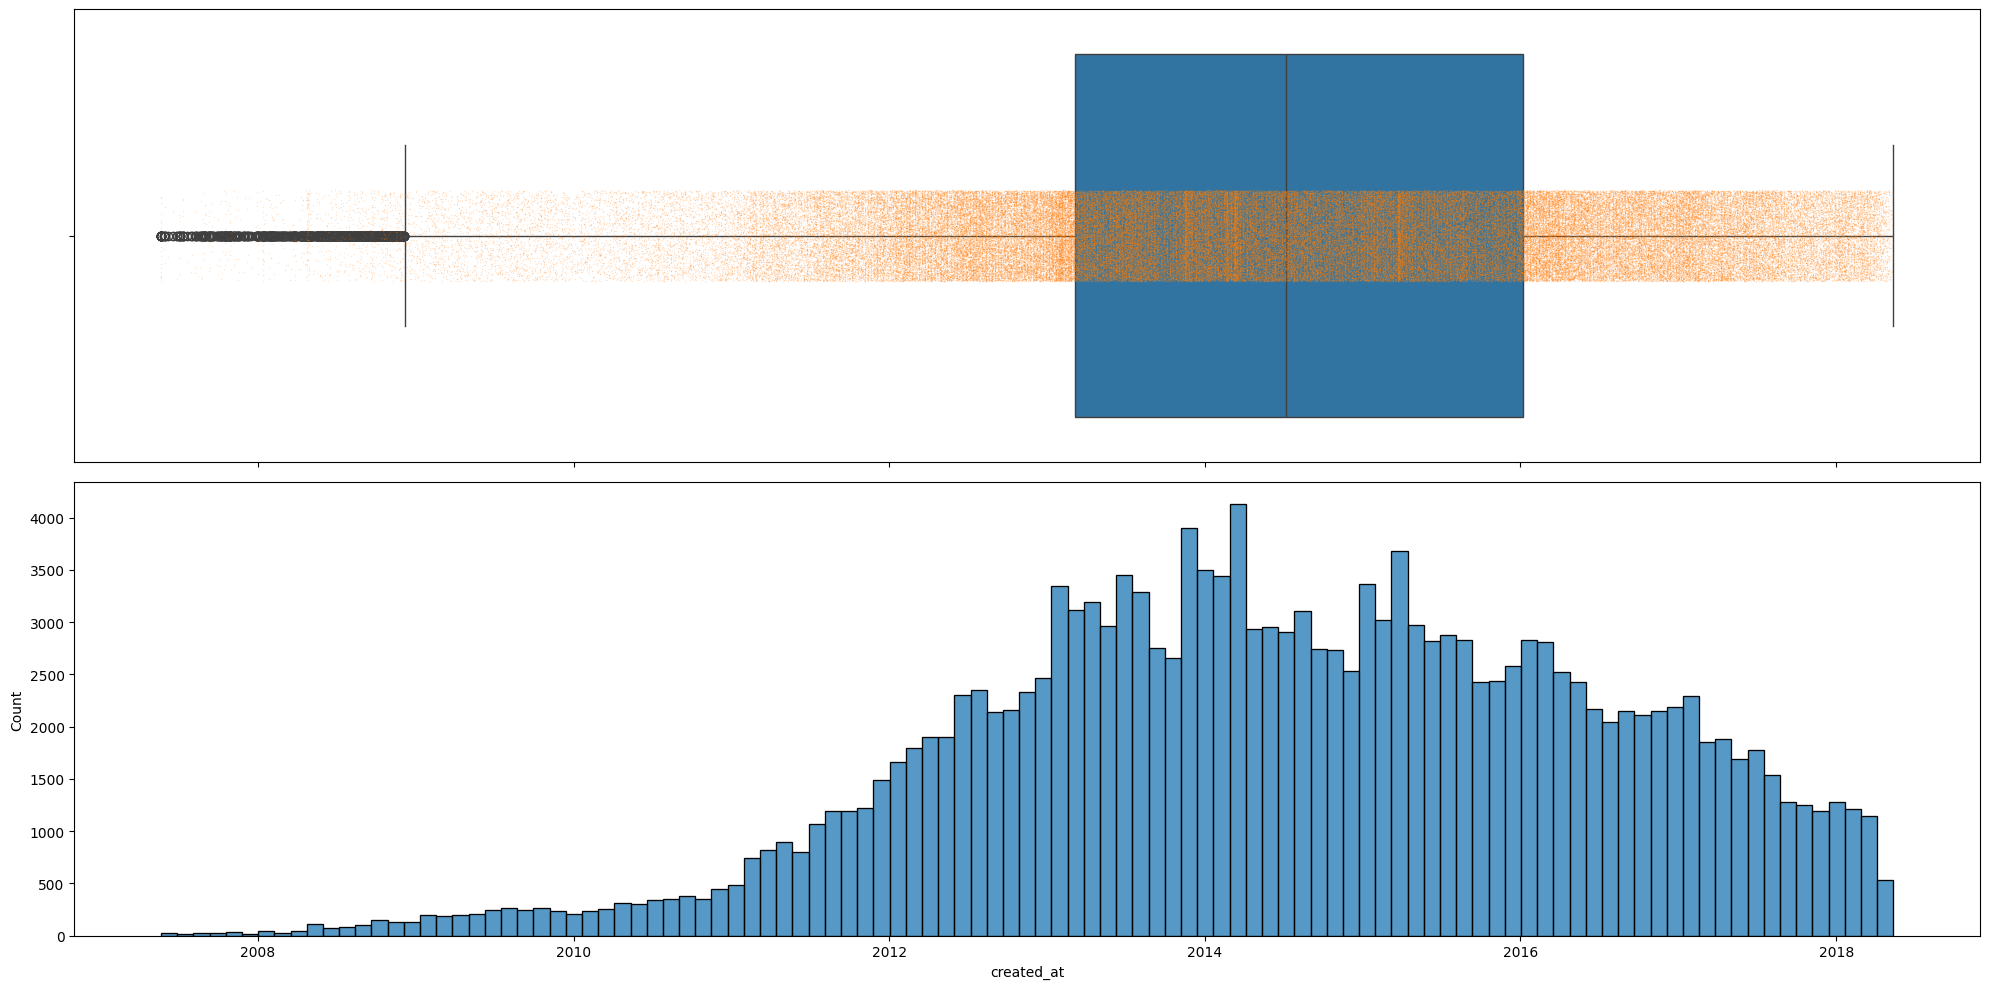

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.boxplot(x=features_df["created_at"], ax=ax[0])
sns.stripplot(x=features_df["created_at"], ax=ax[0], alpha=0.2, size=1)
sns.histplot(features_df["created_at"], ax=ax[1])

plt.tight_layout()

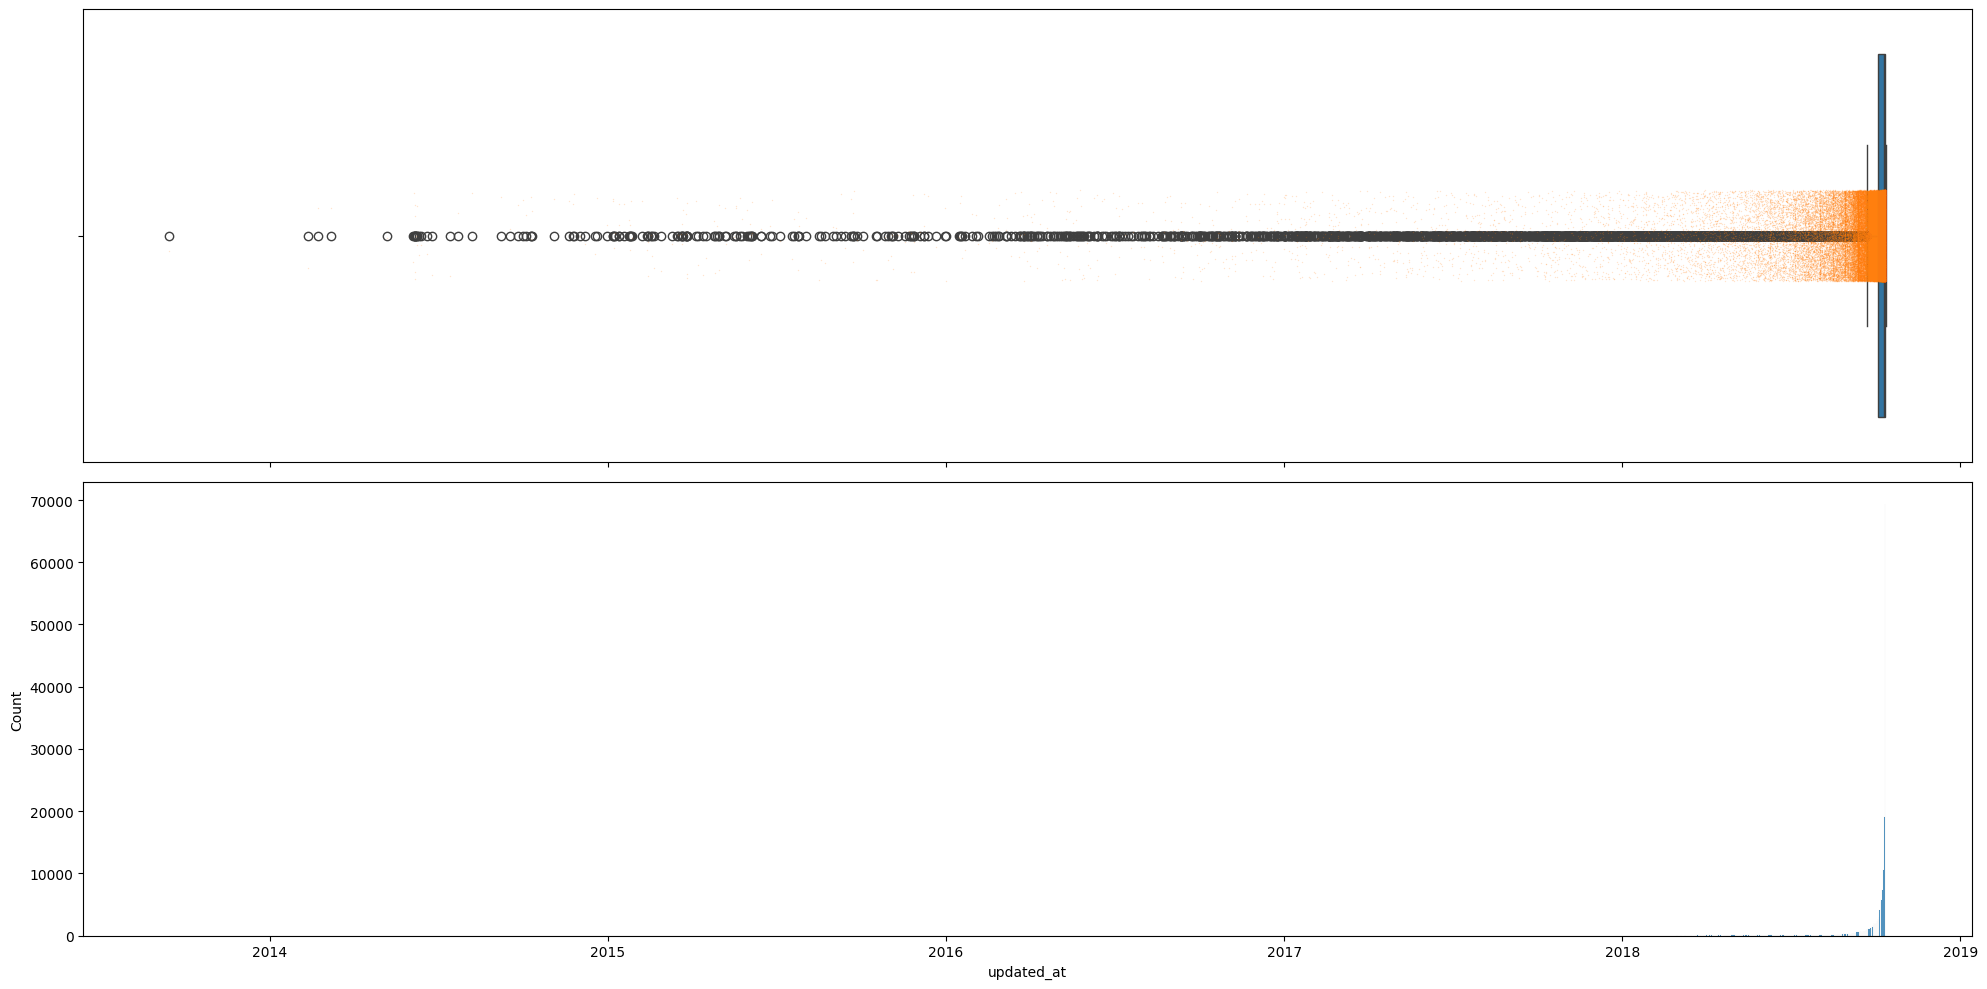

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(20,10), sharex=True)
sns.boxplot(x=features_df["updated_at"], ax=ax[0])
sns.stripplot(x=features_df["updated_at"], ax=ax[0], alpha=0.2, size=1)
sns.histplot(features_df["updated_at"], ax=ax[1])

plt.tight_layout()

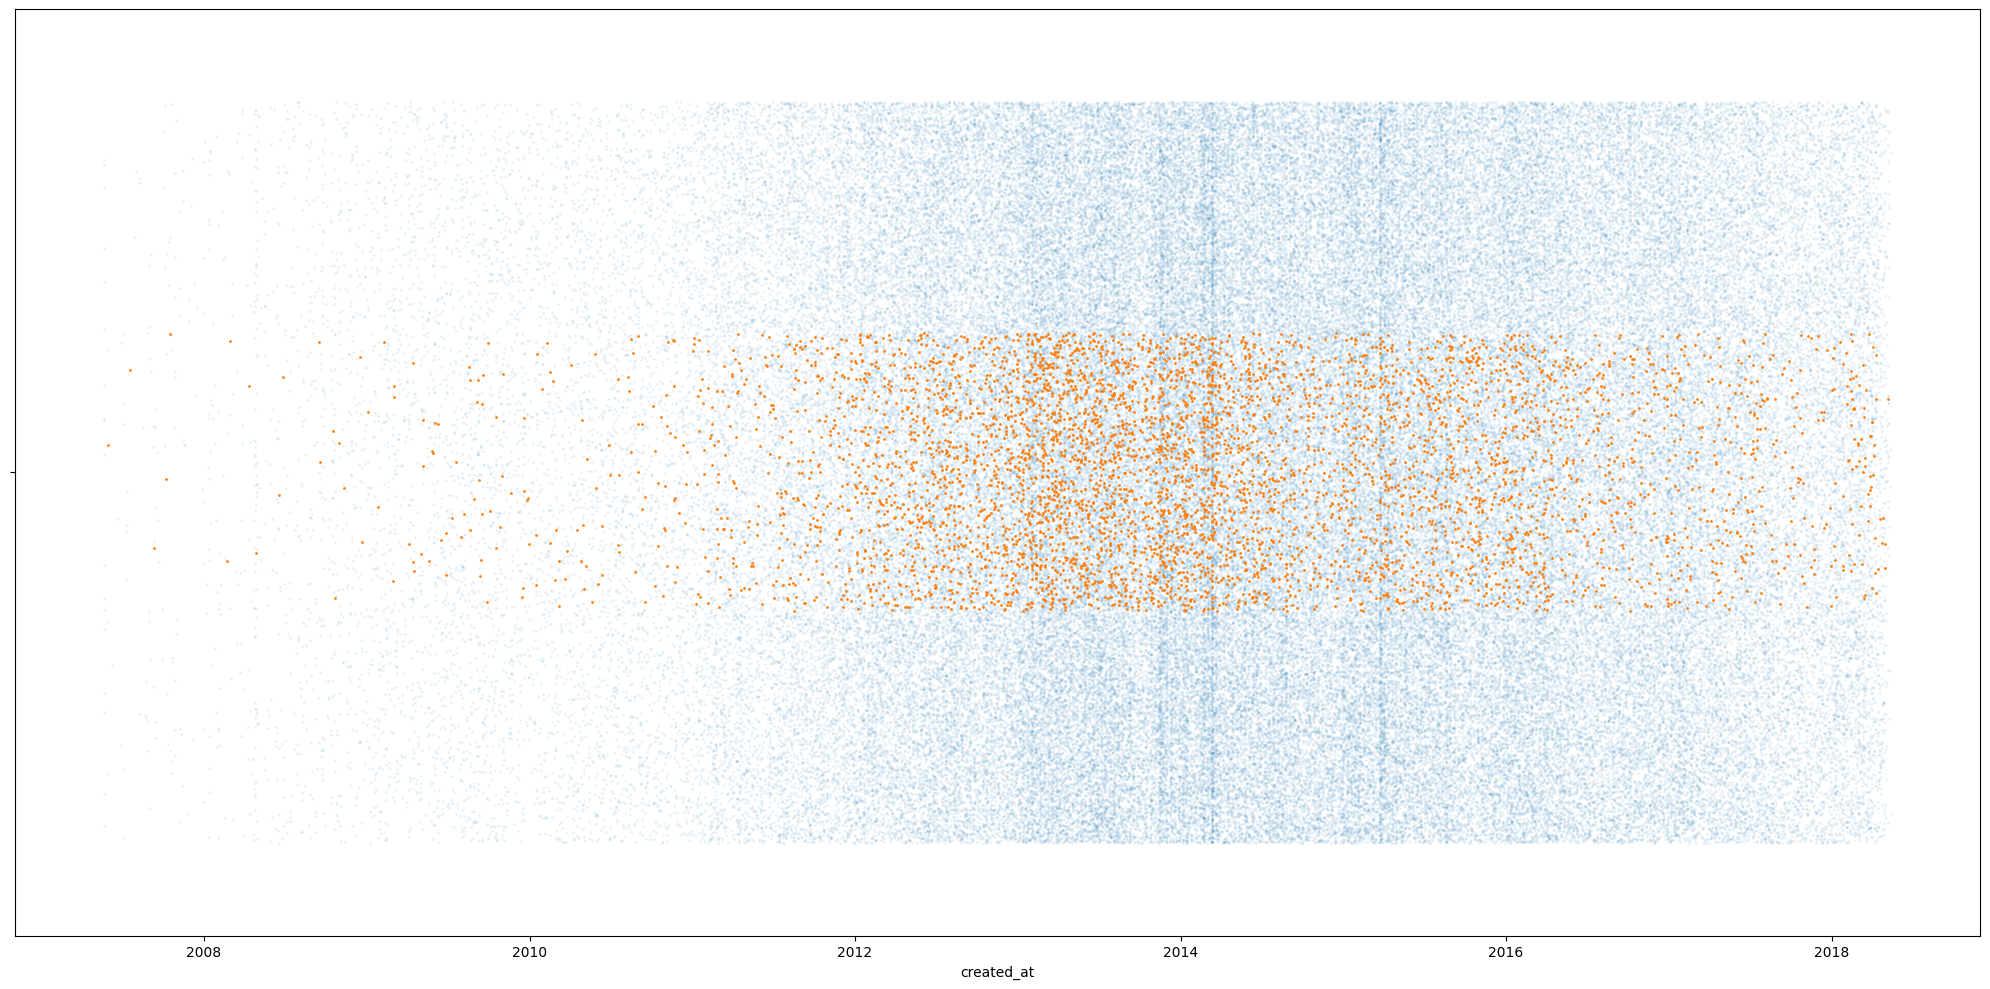

In [9]:
plt.figure(figsize=(20,10))
# sns.stripplot(x=features_df["created_at"], ax=ax[0], alpha=0., size=2, hue=features_df["dead_account"])
sns.stripplot(x="created_at", data=features_df[features_df["dead_account"] == 0], alpha=0.1, size=2, jitter=0.4)
sns.stripplot(x="created_at", data=features_df[features_df["dead_account"] == 1], alpha=1, size=2, jitter=0.15)
plt.tight_layout()

In [10]:
# edges_df[(edges_df["numeric_id_1"] == 0) | (edges_df["numeric_id_2"] == 0)]

In [11]:
# sparse_adj_mat = tgu.to_scipy_sparse_matrix(torch.tensor(edges_df.to_numpy().T))

In [12]:
# plt.figure(figsize=(500,500))
# plt.spy(sparse_adj_mat, ms=1)
# plt.savefig("test.png")

In [13]:
''' Filter accounts which haven't been active recently '''

q1, q2, q3 = np.quantile(features_df["updated_at"], q=[0.25, 0.5, 0.75])
iqr = q3 - q1
lower, upper = q2 - iqr, q2 + iqr

# filtered_df = features_df[(features_df["updated_at"] > lower) & (features_df["updated_at"] < upper)]
#
# remaining_ids = filtered_df["numeric_id"]
# filtered_edges_df = edges_df[
#     edges_df["numeric_id_1"].isin(remaining_ids.values) & edges_df["numeric_id_2"].isin(remaining_ids.values)]

filtered_df = features_df
filtered_edges_df = edges_df

In [14]:
''' Normalize data '''

def normalize(series):
    return (series - series.mean()) / series.std()


mms_date = MinMaxScaler()
mms_life = MinMaxScaler()

normed_df = filtered_df.drop(columns=["numeric_id", "updated_at"])

# tmp = pd.concat([normed_df["created_at"], normed_df["updated_at"]])
# mms_date.fit(tmp.to_numpy().reshape(-1, 1))

normed_df["views"] = normalize(normed_df["views"])
normed_df["life_time"] = normalize(normed_df["life_time"])
normed_df["created_at"] = normalize(normed_df["created_at"])
# normed_df["updated_at"] = normalize(normed_df["updated_at"])
# normed_df["life_time"] = mms_life.fit_transform(normed_df["life_time"].to_numpy().reshape(-1, 1))
# normed_df["created_at"] = mms_date.transform(normed_df["created_at"].to_numpy().reshape(-1, 1))
# normed_df["updated_at"] = mms_date.transform(normed_df["updated_at"].to_numpy().reshape(-1, 1))
# normed_df = pd.get_dummies(normed_df, columns=["language"], drop_first=True, dtype=int)

langs = normed_df["language"].unique()
lang_encoding = {k: v for k, v in zip(langs, range(len(langs)))}
normed_df["language"] = normed_df["language"].replace(lang_encoding)

normed_df.head()

views  mature  life_time  created_at  dead_account  language  affiliate
0 -0.054202       1  -0.800348    0.820491             0         0          1
1 -0.056421       0   1.616852   -1.601095             0         0          0
2  0.058429       1   2.245604   -2.223949             0         0          1
3 -0.056455       0  -0.276388    0.281430             0         0          0
4 -0.055824       0   0.338391   -0.319079             0         0          0

In [15]:
''' Convert to tensors '''

def split_feats_classes(df, class_col_name):
    x = df.drop(columns=[class_col_name])
    y = df[class_col_name]

    return x, y


# normed_np = torch.tensor(normed_df.drop(columns=["mature"]).to_numpy()).float()
# edges_np = torch.tensor(filtered_edges_df.to_numpy())

# mature_ohe = pd.DataFrame({"mature": normed_df["mature"], "not_mature": 1-normed_df["mature"]})
# target_np = torch.tensor(mature_ohe.to_numpy())
# target_np = torch.tensor(normed_df["mature"].to_numpy())

x, y = split_feats_classes(normed_df, "language")
x_np = torch.tensor(x.to_numpy()).float()
y_np = torch.tensor(y.to_numpy())
edges_np = torch.tensor(filtered_edges_df.to_numpy())

In [16]:
''' Train Test Val split '''

node_idx = normed_df.index.values

train_idx, test_idx = train_test_split(node_idx, test_size=0.25)
val_idx, test_idx = train_test_split(test_idx, test_size=0.25)

train_mask = torch.tensor(normed_df.index.isin(train_idx))
val_mask = torch.tensor(normed_df.index.isin(val_idx))
test_mask = torch.tensor(normed_df.index.isin(test_idx))

In [17]:
''' Construct TorchGeo graph '''

graph = Data(x=x_np,
             y=y_np,
             edge_index=edges_np.t().contiguous(),
             train_mask=train_mask,
             val_mask=val_mask,
             test_mask=test_mask)
graph

Data(x=[168114, 6], edge_index=[2, 6797557], y=[168114], train_mask=[168114], val_mask=[168114], test_mask=[168114])

In [18]:
''' Declare GCN architecture '''

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes):
        super().__init__()
        self.conv1 = GCNConv(graph.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)

        x = self.lin(x)

        return x

In [19]:
''' Training loop '''

def train(model, loader):
    model.train()

    total_loss = 0
    total_examples = 0

    for batch in loader:
        batch.to(device)
        optimizer.zero_grad()

        out = model(batch.x, batch.edge_index.to(device))
        loss = F.cross_entropy(out[batch.train_mask], batch.y[batch.train_mask])

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_nodes
        total_examples += batch.num_nodes

    return total_loss / total_examples


def test(model, graph):
    model.eval()

    out = model(graph.x.to(device), graph.edge_index.to(device))
    preds = F.log_softmax(out, dim=-1).argmax(1)
    # print(f"Preds: {preds}, torch.unique(preds)")
    # print(f"True: {graph.y}")
    correct = preds.eq(graph.y.to(device))

    accs = []
    for _, mask in graph("train_mask", "val_mask", "test_mask"):
        accs.append(correct[mask].sum().item() / mask.sum().item())

    return accs

In [20]:
train = False

num_classes = len(lang_encoding)
hc = 32

In [21]:
''' Setup torch inputs and variables for training loop '''

if train:
    # model = GCN(hc, num_classes).to(device)
    model = torch.load("best_model.pk").to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, momentum=0.9)
    
    # loader = GraphSAINTNodeSampler(graph, batch_size=512, num_steps=16)
    loader = [graph]
    
    best_val_acc = 0
    best_test_acc = 0
    
    loss_hist = []
    val_hist = []
    test_hist = []
    
    for epoch in range(10000):
        loss = train(model, loader)
        train_acc, val_acc, test_acc = test(model, graph)
    
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
    
            torch.save(model, f"best_model.pk")
    
        if epoch % 5 == 0:
            print(
                f"In epoch {epoch}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}), test acc: {test_acc:.3f} (best {best_test_acc:.3f})"
            )

In [22]:
model = torch.load("language_prediction_final_1.pk")
model.eval()

out = model(graph.x.to(device), graph.edge_index.to(device))
preds = F.log_softmax(out, dim=-1).argmax(1).to("cpu")

In [23]:
labels = ["EN", "FR","KO","JA","RU","PL","DE","ES","IT","PT","OTHER","TR","ZH","SV","NL","TH","CS","DA","HU","FI","NO"]
lang_encoding

{'EN': 0,
 'FR': 1,
 'KO': 2,
 'JA': 3,
 'RU': 4,
 'PL': 5,
 'DE': 6,
 'ES': 7,
 'IT': 8,
 'PT': 9,
 'OTHER': 10,
 'TR': 11,
 'ZH': 12,
 'SV': 13,
 'NL': 14,
 'TH': 15,
 'CS': 16,
 'DA': 17,
 'HU': 18,
 'FI': 19,
 'NO': 20}

In [24]:
from IPython.display import display_html

precision = metrics.precision_score(graph.y, preds, average=None, zero_division=np.nan)
recall = metrics.recall_score(graph.y, preds, average=None, zero_division=np.nan)
f1 = metrics.f1_score(graph.y, preds, average=None, zero_division=np.nan)

metrics_dict = {
    "Language": labels,
    "Precision": precision,
    "Recall": recall,
    "F1": f1
}
metrics_df = pd.DataFrame(metrics_dict) 

precision_summary = metrics.precision_score(graph.y, preds, average="weighted", zero_division=np.nan)
recall_summary = metrics.recall_score(graph.y, preds, average="weighted", zero_division=np.nan)
f1_summary = metrics.f1_score(graph.y, preds, average="weighted", zero_division=np.nan)

accuracy = metrics.accuracy_score(graph.y, preds)
summary_dict = {
    "Accuracy": [accuracy],
    "Precision": [precision_summary],
    "Recall": [recall_summary],
    "F1": [f1_summary]
}
summary_df = pd.DataFrame(summary_dict) 


df1_styler = metrics_df.style.set_table_attributes("style='display:inline'").set_caption('Split Stats')
df2_styler = summary_df.style.set_table_attributes("style='display:inline'").set_caption('Summary')
display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

Split Stats 
 
 
   
 Language 
 Precision 
 Recall 
 F1 
 
 
 
 
 0 
 EN 
 0.917261 
 0.981360 
 0.948228 
 
 
 1 
 FR 
 0.933431 
 0.847625 
 0.888461 
 
 
 2 
 KO 
 0.742222 
 0.687243 
 0.713675 
 
 
 3 
 JA 
 0.820059 
 0.418990 
 0.554613 
 
 
 4 
 RU 
 0.765290 
 0.687824 
 0.724492 
 
 
 5 
 PL 
 0.914449 
 0.509534 
 0.654422 
 
 
 6 
 DE 
 0.909704 
 0.858082 
 0.883140 
 
 
 7 
 ES 
 0.753457 
 0.716968 
 0.734760 
 
 
 8 
 IT 
 0.671204 
 0.521138 
 0.586728 
 
 
 9 
 PT 
 0.759961 
 0.609227 
 0.676297 
 
 
 10 
 OTHER 
 1.000000 
 0.001400 
 0.002795 
 
 
 11 
 TR 
 0.853432 
 0.595855 
 0.701754 
 
 
 12 
 ZH 
 0.933948 
 0.859972 
 0.895434 
 
 
 13 
 SV 
 0.406250 
 0.060890 
 0.105906 
 
 
 14 
 NL 
 nan 
 0.000000 
 nan 
 
 
 15 
 TH 
 0.793522 
 0.930380 
 0.856519 
 
 
 16 
 CS 
 0.919087 
 0.769097 
 0.837429 
 
 
 17 
 DA 
 0.615044 
 0.276342 
 0.381344 
 
 
 18 
 HU 
 0.870968 
 0.189696 
 0.311538 
 
 
 19 
 FI 
 0.907407 
 0.075153 
 0.138810 
 
 
 20 
 NO 
 nan 
 0.000000 
 nan 
 
 
 

 
 Summary 
 
 
   
 Accuracy 
 Precision 
 Recall 
 F1 
 
 
 
 
 0 
 0.902072 
 0.897816 
 0.902072 
 0.893462

Text(220.72222222222223, 0.5, 'Actual')

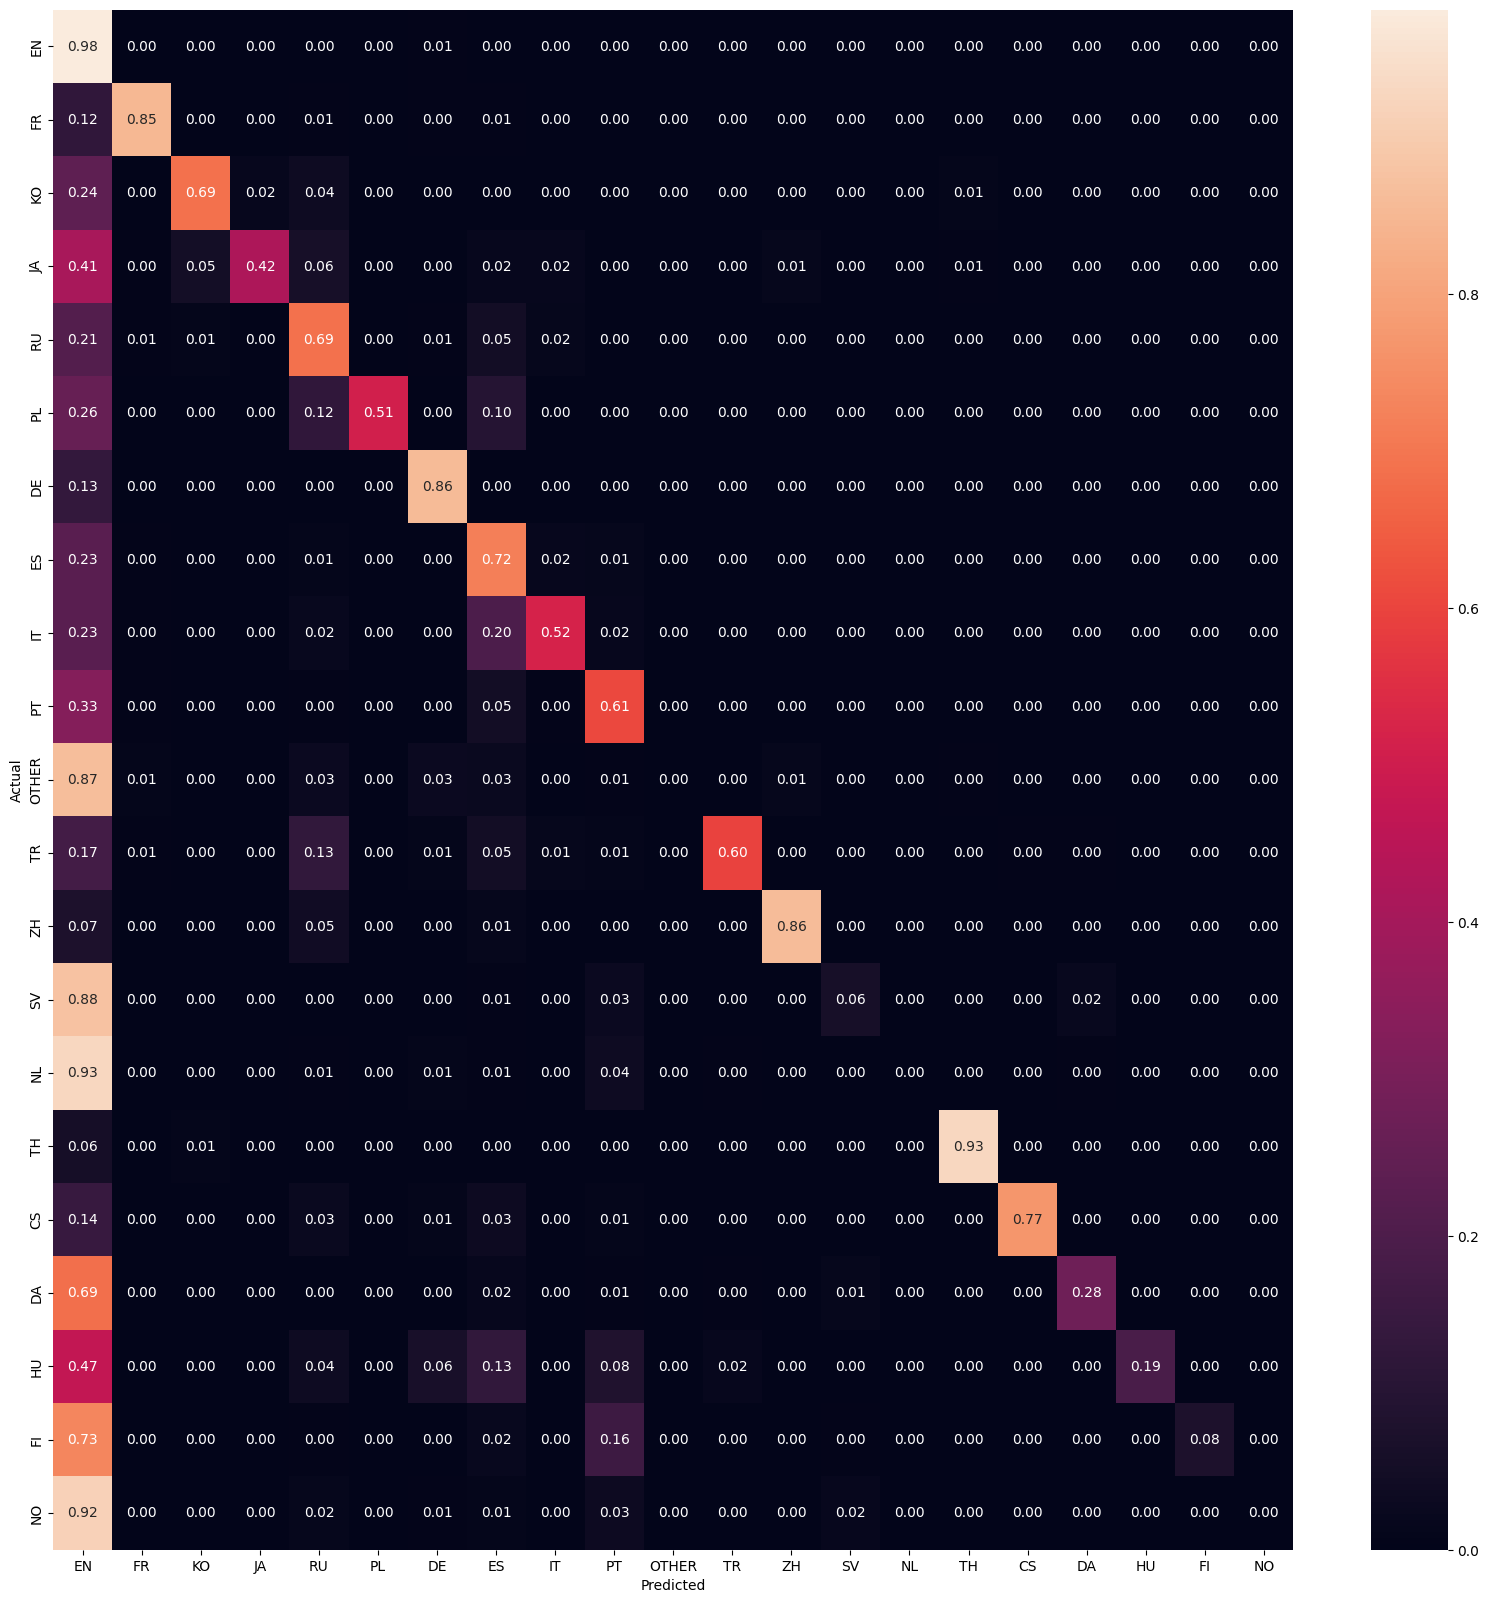

In [25]:
plt.figure(figsize=(20,20))

cm = metrics.confusion_matrix(graph.y, preds)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

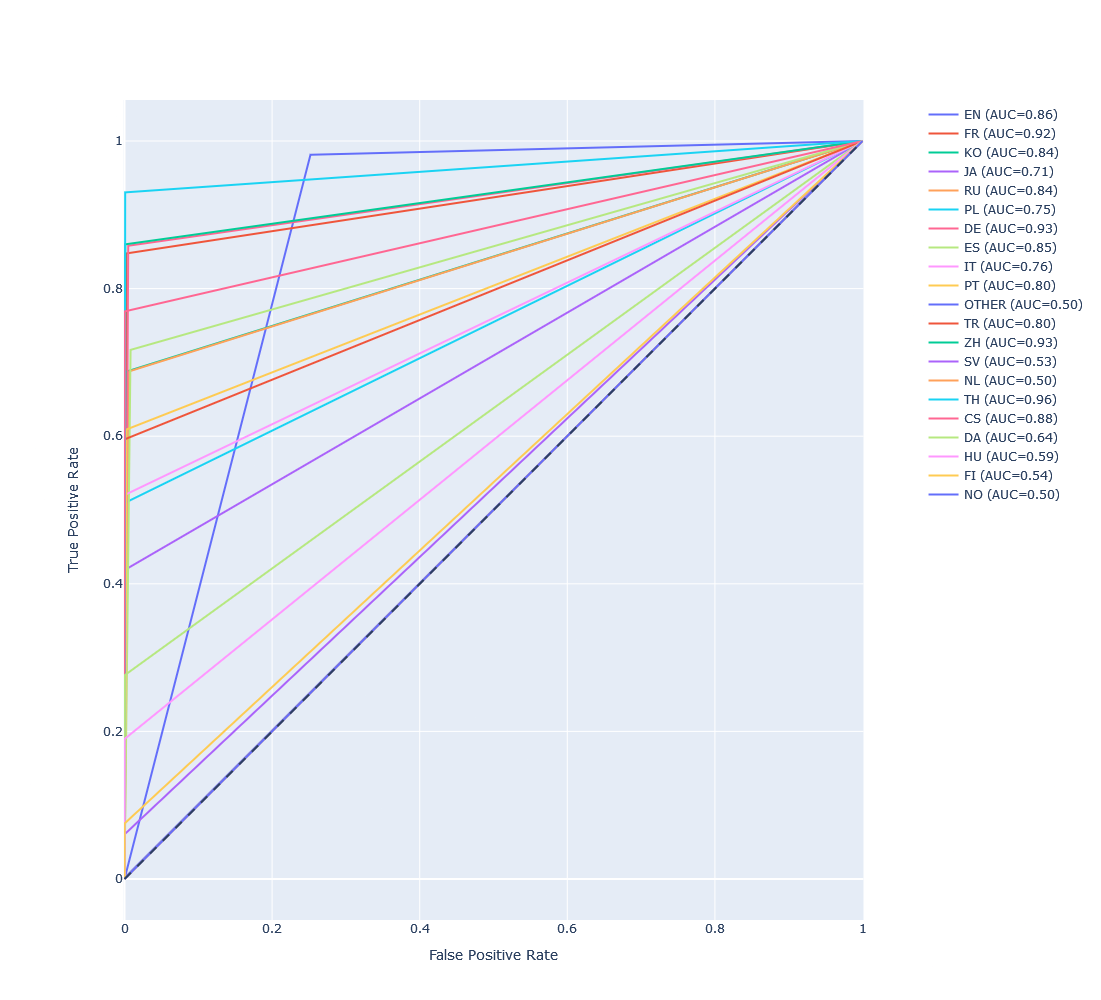

In [26]:
binarizer = LabelBinarizer()
binarizer.fit(graph.y)

ohe_preds = binarizer.transform(preds)
ohe_y = binarizer.transform(graph.y)

fig = go.Figure()
fig.add_shape(
    type="line", line=dict(dash="dash"),
    x0=0, y0=0, x1=1, y1=1
)

for lang, enc in lang_encoding.items():
    fpr, tpr, _ = metrics.roc_curve(ohe_y[:, enc], ohe_preds[:, enc])
    auc_score = metrics.roc_auc_score(ohe_y[:, enc], ohe_preds[:, enc])

    name=f"{lang} (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode="lines"))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=1000, height=1000
)
fig.show()